## Required Packages

In [113]:
#import uproot
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from collections import namedtuple, defaultdict
#import open3d as o3d
import random
random.seed(42)
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import add_self_loops
from torch_geometric.transforms import ToUndirected
from torchvision import transforms
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import joblib
from torch.nn import BatchNorm1d

## Loading Test Data 

In [3]:
hf_cellFeaturesScaled_neighbor= h5py.File("./cellFeaturesScaled_test_100evs.hdf5", 'r')

hf_test_edge_source_true_BD = h5py.File("./test_edge_source_true_BD.hdf5", 'r')
hf_test_edge_dest_true_BD = h5py.File("./test_edge_dest_true_BD.hdf5", 'r')
hf_test_edge_source_true_noBD = h5py.File("./test_edge_source_true_noBD.hdf5", 'r')
hf_test_edge_dest_true_noBD = h5py.File("./test_edge_dest_true_noBD.hdf5", 'r')

hf_test_edge_source_bkg_lone_BD = h5py.File("./test_edge_source_bkg_lone_BD.hdf5", 'r')
hf_test_edge_dest_bkg_lone_BD = h5py.File("./test_edge_dest_bkg_lone_BD.hdf5", 'r')
hf_test_edge_source_bkg_lone_noBD = h5py.File("./test_edge_source_bkg_lone_noBD.hdf5", 'r')
hf_test_edge_dest_bkg_lone_noBD = h5py.File("./test_edge_dest_bkg_lone_noBD.hdf5", 'r')

hf_test_edge_source_bkg_cluster_lone_BD = h5py.File("./test_edge_source_bkg_cluster_lone_BD.hdf5", 'r')
hf_test_edge_dest_bkg_cluster_lone_BD = h5py.File("./test_edge_dest_bkg_cluster_lone_BD.hdf5", 'r')
hf_test_edge_source_bkg_cluster_lone_noBD = h5py.File("./test_edge_source_bkg_cluster_lone_noBD.hdf5", 'r')
hf_test_edge_dest_bkg_cluster_lone_noBD = h5py.File("./test_edge_dest_bkg_cluster_lone_noBD.hdf5", 'r')

hf_test_edge_source_bkg_cluster_cluster_BD = h5py.File("./test_edge_source_bkg_cluster_cluster_BD.hdf5", 'r')
hf_test_edge_dest_bkg_cluster_cluster_BD = h5py.File("./test_edge_dest_bkg_cluster_cluster_BD.hdf5", 'r')
hf_test_edge_source_bkg_cluster_cluster_noBD = h5py.File("./test_edge_source_bkg_cluster_cluster_noBD.hdf5", 'r')
hf_test_edge_dest_bkg_cluster_cluster_noBD = h5py.File("./test_edge_dest_bkg_cluster_cluster_noBD.hdf5", 'r')

In [4]:
cellFeaturesScaled = hf_cellFeaturesScaled_neighbor.get("cellFeatures_testS")[:]

test_edge_source_true_BD = hf_test_edge_source_true_BD.get("test_edge_source_true_BD")[:]
test_edge_dest_true_BD = hf_test_edge_dest_true_BD.get("test_edge_dest_true_BD")[:]
test_edge_source_true_noBD = hf_test_edge_source_true_noBD.get("test_edge_source_true_noBD")[:]
test_edge_dest_true_noBD = hf_test_edge_dest_true_noBD.get("test_edge_dest_true_noBD")[:]

test_edge_source_bkg_lone_BD = hf_test_edge_source_bkg_lone_BD.get("test_edge_source_bkg_lone_BD")[:]
test_edge_dest_bkg_lone_BD = hf_test_edge_dest_bkg_lone_BD.get("test_edge_dest_bkg_lone_BD")[:]
test_edge_source_bkg_lone_noBD = hf_test_edge_source_bkg_lone_noBD.get("test_edge_source_bkg_lone_noBD")[:]
test_edge_dest_bkg_lone_noBD = hf_test_edge_dest_bkg_lone_noBD.get("test_edge_dest_bkg_lone_noBD")[:]

test_edge_source_bkg_lone_BD = hf_test_edge_source_bkg_lone_BD.get("test_edge_source_bkg_lone_BD")[:]
test_edge_dest_bkg_lone_BD = hf_test_edge_dest_bkg_lone_BD.get("test_edge_dest_bkg_lone_BD")[:]
test_edge_source_bkg_lone_noBD = hf_test_edge_source_bkg_lone_noBD.get("test_edge_source_bkg_lone_noBD")[:]
test_edge_dest_bkg_lone_noBD = hf_test_edge_dest_bkg_lone_noBD.get("test_edge_dest_bkg_lone_noBD")[:]

test_edge_source_bkg_cluster_lone_BD = hf_test_edge_source_bkg_cluster_lone_BD.get("test_edge_source_bkg_cluster_lone_BD")[:]
test_edge_dest_bkg_cluster_lone_BD = hf_test_edge_dest_bkg_cluster_lone_BD.get("test_edge_dest_bkg_cluster_lone_BD")[:]
test_edge_source_bkg_cluster_lone_noBD = hf_test_edge_source_bkg_cluster_lone_noBD.get("test_edge_source_bkg_cluster_lone_noBD")[:]
test_edge_dest_bkg_cluster_lone_noBD = hf_test_edge_dest_bkg_cluster_lone_noBD.get("test_edge_dest_bkg_cluster_lone_noBD")[:]

test_edge_source_bkg_cluster_cluster_BD = hf_test_edge_source_bkg_cluster_cluster_BD.get("test_edge_source_bkg_cluster_cluster_BD")[:]
test_edge_dest_bkg_cluster_cluster_BD = hf_test_edge_dest_bkg_cluster_cluster_BD.get("test_edge_dest_bkg_cluster_cluster_BD")[:]
test_edge_source_bkg_cluster_cluster_noBD = hf_test_edge_source_bkg_cluster_cluster_noBD.get("test_edge_source_bkg_cluster_cluster_noBD")[:]
test_edge_dest_bkg_cluster_cluster_noBD = hf_test_edge_dest_bkg_cluster_cluster_noBD.get("test_edge_dest_bkg_cluster_cluster_noBD")[:]


In [5]:
hf_cellFeaturesScaled_neighbor.close()

hf_test_edge_source_true_BD.close()
hf_test_edge_dest_true_BD.close()
hf_test_edge_source_true_noBD.close()
hf_test_edge_dest_true_noBD.close()

hf_test_edge_source_bkg_lone_BD.close()
hf_test_edge_dest_bkg_lone_BD.close()
hf_test_edge_source_bkg_lone_noBD.close()
hf_test_edge_dest_bkg_lone_noBD.close()

hf_test_edge_source_bkg_cluster_lone_BD.close()
hf_test_edge_dest_bkg_cluster_lone_BD.close()
hf_test_edge_source_bkg_cluster_lone_noBD.close()
hf_test_edge_dest_bkg_cluster_lone_noBD.close()

hf_test_edge_source_bkg_cluster_cluster_BD.close()
hf_test_edge_dest_bkg_cluster_cluster_BD.close()
hf_test_edge_source_bkg_cluster_cluster_noBD.close()
hf_test_edge_dest_bkg_cluster_cluster_noBD.close()

In [6]:
cellFeaturesScaled.shape

(100, 187652, 8)

In [7]:
x = torch.tensor(cellFeaturesScaled, dtype=torch.float)

In [8]:
x[0].shape

torch.Size([187652, 8])

## Preparing Bidirectional and Unidirectional edges for inference

In [9]:
edge_index_true = torch.tensor([test_edge_source_true_BD, test_edge_dest_true_BD], dtype=torch.long)
edge_index_bkg_lone = torch.tensor([test_edge_source_bkg_lone_BD, test_edge_dest_bkg_lone_BD], dtype=torch.long)
edge_index_bkg_cluster_lone = torch.tensor([test_edge_source_bkg_cluster_lone_BD, test_edge_dest_bkg_cluster_lone_BD], dtype=torch.long)
edge_index_bkg_cluster_cluster = torch.tensor([test_edge_source_bkg_cluster_cluster_BD, test_edge_dest_bkg_cluster_cluster_BD], dtype=torch.long)

/tmp/ipykernel_559685/3383178367.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pscratch/sd/s/swowner/pytorch-build/pytorch/2.0.1/pytorch/torch/csrc/utils/tensor_new.cpp:245.)
  edge_index_true = torch.tensor([test_edge_source_true_BD, test_edge_dest_true_BD], dtype=torch.long)


In [10]:
edge_index_true.shape

torch.Size([2, 100, 18000])

In [11]:
edge_index_true_ch = edge_index_true.permute(1, 0, 2)
edge_index_bkg_lone_ch = edge_index_bkg_lone.permute(1, 0, 2)
edge_index_bkg_cluster_lone_ch = edge_index_bkg_cluster_lone.permute(1, 0, 2)
edge_index_bkg_cluster_cluster_ch = edge_index_bkg_cluster_cluster.permute(1, 0, 2)

In [12]:
edge_index_true_ch.shape

torch.Size([100, 2, 18000])

In [13]:
edge_index_true_out = torch.tensor([test_edge_source_true_noBD, test_edge_dest_true_noBD], dtype=torch.long)
edge_index_bkg_lone_out = torch.tensor([test_edge_source_bkg_lone_noBD, test_edge_dest_bkg_lone_noBD], dtype=torch.long)
edge_index_bkg_cluster_lone_out = torch.tensor([test_edge_source_bkg_cluster_lone_noBD, test_edge_dest_bkg_cluster_lone_noBD], dtype=torch.long)
edge_index_bkg_cluster_cluster_out = torch.tensor([test_edge_source_bkg_cluster_cluster_noBD, test_edge_dest_bkg_cluster_cluster_noBD], dtype=torch.long)

In [14]:
edge_index_true_out.shape

torch.Size([2, 100, 9000])

In [15]:
edge_index_true_out_ch = edge_index_true_out.permute(1, 0, 2)
edge_index_bkg_lone_out_ch = edge_index_true_out.permute(1, 0, 2)
edge_index_bkg_cluster_lone_out_ch = edge_index_bkg_cluster_lone_out.permute(1, 0, 2)
edge_index_bkg_cluster_cluster_out_ch = edge_index_bkg_cluster_cluster_out.permute(1, 0, 2)

In [16]:
edge_index_true_out_ch.shape

torch.Size([100, 2, 9000])

## Pytorch specific customizing for true and 3 different bkgs

In [17]:
# Generate data_list for test
data_list_true = []
for i in range(100):
    x_mat = x[i]
    edge_index = edge_index_true_ch[i]
    edge_index, _ = add_self_loops(edge_index)
    data = Data(x=x_mat, edge_index=edge_index, edge_index_out = edge_index_true_out_ch[i])
    data = ToUndirected()(data)
    data_list_true.append(data)

In [18]:
# Generate data_list for test
data_list_bkg_lone = []
for i in range(100):
    x_mat = x[i]
    edge_index = edge_index_bkg_lone_ch[i]
    edge_index, _ = add_self_loops(edge_index)
    data = Data(x=x_mat, edge_index=edge_index, edge_index_out = edge_index_bkg_lone_out_ch[i])
    data = ToUndirected()(data)
    data_list_bkg_lone.append(data)

In [19]:
# Generate data_list for test
data_list_bkg_cluster_lone = []
for i in range(100):
    x_mat = x[i]
    edge_index = edge_index_bkg_cluster_lone_ch[i]
    edge_index, _ = add_self_loops(edge_index)
    data = Data(x=x_mat, edge_index=edge_index, edge_index_out = edge_index_bkg_cluster_lone_out_ch[i])
    data = ToUndirected()(data)
    data_list_bkg_cluster_lone.append(data)

In [20]:
# Generate data_list for test
data_list_bkg_cluster_cluster = []
for i in range(100):
    x_mat = x[i]
    edge_index = edge_index_bkg_cluster_cluster_ch[i]
    edge_index, _ = add_self_loops(edge_index)
    data = Data(x=x_mat, edge_index=edge_index, edge_index_out = edge_index_bkg_cluster_cluster_out_ch[i])
    data = ToUndirected()(data)
    data_list_bkg_cluster_cluster.append(data)

In [21]:
ind0 = data_list_true[0].edge_index
ind1 = data_list_true[1].edge_index
ind2 = data_list_true[2].edge_index

In [22]:
print(ind0.shape)
print(ind1.shape)
print(ind2.shape)

torch.Size([2, 205549])
torch.Size([2, 205583])
torch.Size([2, 205632])


In [23]:
ind0[0,:]

tensor([     0,      1,      2,  ..., 187548, 187548, 187548])

In [24]:
ind1[0,:]

tensor([     0,      1,      2,  ..., 187582, 187582, 187582])

In [25]:
ind2[:,:]

tensor([[     0,      1,      2,  ..., 187630, 187631, 187631],
        [     0,      1,      2,  ..., 187630, 186838, 187631]])

In [26]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data_list):
        self.data_list = data_list

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        return self.data_list[idx]

In [28]:
def collate_true(data_list_true):
    batch_x = [data.x for data in data_list_true]
    batch_edge_index = [data.edge_index for data in data_list_true]
    batch_edge_index_out = [data.edge_index_out for data in data_list_true]
    #batch_y = [data.y for data in data_list]

    return batch_x, batch_edge_index, batch_edge_index_out

In [29]:
def collate_bkg_lone(data_list_bkg_lone):
    batch_x = [data.x for data in data_list_bkg_lone]
    batch_edge_index = [data.edge_index for data in data_list_bkg_lone]
    batch_edge_index_out = [data.edge_index_out for data in data_list_bkg_lone]
    #batch_y = [data.y for data in data_list]

    return batch_x, batch_edge_index, batch_edge_index_out

In [30]:
def collate_bkg_cluster_lone(data_list_bkg_cluster_lone):
    batch_x = [data.x for data in data_list_bkg_cluster_lone]
    batch_edge_index = [data.edge_index for data in data_list_bkg_cluster_lone]
    batch_edge_index_out = [data.edge_index_out for data in data_list_bkg_cluster_lone]
    #batch_y = [data.y for data in data_list]

    return batch_x, batch_edge_index, batch_edge_index_out

In [31]:
def collate_bkg_cluster_cluster(data_list_bkg_cluster_cluster):
    batch_x = [data.x for data in data_list_bkg_cluster_cluster]
    batch_edge_index = [data.edge_index for data in data_list_bkg_cluster_cluster]
    batch_edge_index_out = [data.edge_index_out for data in data_list_bkg_cluster_cluster]
    #batch_y = [data.y for data in data_list]

    return batch_x, batch_edge_index, batch_edge_index_out

In [32]:
custom_dataset_true = CustomDataset(data_list_true)
custom_dataset_bkg_lone = CustomDataset(data_list_bkg_lone)
custom_dataset_bkg_cluster_lone = CustomDataset(data_list_bkg_cluster_lone)
custom_dataset_bkg_cluster_cluster = CustomDataset(data_list_bkg_cluster_cluster)

In [33]:
batch_size = 20
data_loader_true = torch.utils.data.DataLoader(custom_dataset_true, batch_size=batch_size, collate_fn=collate_true)
data_loader_bkg_lone = torch.utils.data.DataLoader(custom_dataset_bkg_lone, batch_size=batch_size, collate_fn=collate_bkg_lone)
data_loader_bkg_cluster_lone = torch.utils.data.DataLoader(custom_dataset_bkg_cluster_lone, batch_size=batch_size, collate_fn=collate_bkg_cluster_lone)
data_loader_bkg_cluster_cluster = torch.utils.data.DataLoader(custom_dataset_bkg_cluster_cluster, batch_size=batch_size, collate_fn=collate_bkg_cluster_cluster)

In [34]:
#for batch_x, batch_edge_index, batch_edge_index_out, _ in data_loader:
#    print(len(batch_edge_index))

In [35]:
for batch_x, batch_edge_index, batch_edge_index_out in data_loader_true:
    print(len(batch_edge_index))

20
20
20
20
20


In [36]:
#y_test.shape

In [37]:
data.edge_index.shape

torch.Size([2, 188671])

In [39]:
x.size(1)

187652

In [114]:
# Define the GNN model for edge classification
class EdgeClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(EdgeClassifier, self).__init__()

        # Node embedding layer
        self.node_embedding = nn.Linear(input_dim, hidden_dim)

        # Graph convolutional layers
        self.conv1 = GCNConv(hidden_dim, 128)
        self.bn1 = BatchNorm1d(128)
        
        self.conv2 = GCNConv(128, 64)
        self.bn2 = BatchNorm1d(64)
        
        # Edge classification layer
        self.fc = nn.Linear(128 , output_dim)

    def forward(self, x, edge_index, edge_index_out):
        edge_index = edge_index
        x = self.node_embedding(x)
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = torch.relu(x)

        # Edge representations
        edge_index_to_compare = edge_index_out
        edge_rep = torch.cat([x[edge_index_to_compare[0]], x[edge_index_to_compare[1]]], dim=1)

        # Edge classification
        edge_scores = torch.sigmoid(self.fc(edge_rep))

        return edge_scores

In [156]:
input_size = 8
hidden_dim = 256
output_dim = 1
path = "./GNNCalo_net_cluster_500evs_rand_batch3.pth"
model = EdgeClassifier(input_size, hidden_dim, output_dim )
#model.load(torch.load(path))
model.load_state_dict(torch.load(path))
#model.eval()
#model = torch.load(path)

<All keys matched successfully>

In [157]:
print(model)

EdgeClassifier(
  (node_embedding): Linear(in_features=8, out_features=256, bias=True)
  (conv1): GCNConv(256, 128)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GCNConv(128, 64)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


In [177]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
all_scores = []  # List to collect all edge scores

with torch.no_grad():
    model.eval()
    model.to(device)
    
    for batch_x, batch_edge_index, batch_edge_index_out in data_loader_bkg_lone:
        batch_x = torch.stack(batch_x).to(device)
        batch_edge_index = [edge_index.to(device) for edge_index in batch_edge_index]
        batch_edge_index_out = [edge_index.to(device) for edge_index in batch_edge_index_out]
        
        for i in range(len(batch_edge_index)):
            test_edge_scores = model(batch_x[i], batch_edge_index[i], batch_edge_index_out[i])
            all_scores.append(test_edge_scores)

# Concatenate the edge scores from all batches
all_scores = torch.cat(all_scores, dim=0)

In [178]:
all_scores.shape

torch.Size([900000, 1])

In [179]:
all_scores = all_scores.cpu()

In [180]:
test_edge_scores_np = all_scores.detach().numpy()

In [181]:
test_edge_scores_np.shape

(900000, 1)

(0.0, 1.0)

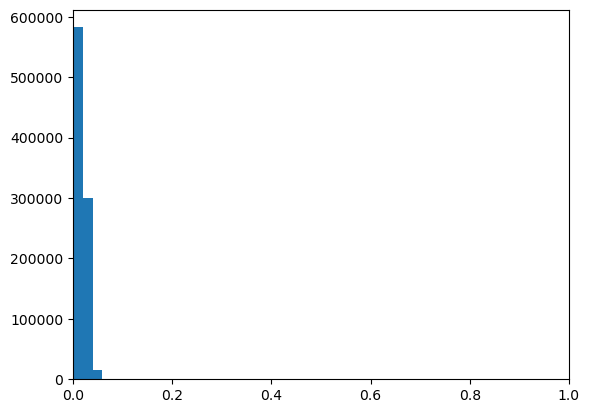

In [182]:
plt.hist(test_edge_scores_np, bins=50)
#plt.yscale('log')
plt.xlim(0,1)